The organizer provides the guideline:

https://mofc.unic.ac.cy/m5-competition/

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


sns.set(style='darkgrid')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
path = "/kaggle/input/m5-forecasting-accuracy"

sell_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sales_train_evaluation = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv"))
calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
sales_train_validation = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [ ]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            
    return df 

sell_prices = downcast(sell_prices)
sales_train_evaluation = downcast(sales_train_evaluation)
calendar = downcast(calendar)
sales_train_validation = downcast(sales_train_validation)

print("Done")

## Check data

### sell_prices.csv

In [ ]:
sell_prices.info()

In [ ]:
sell_prices.isnull().sum()

There is no null value in sell_prices.csv

In [ ]:
sell_prices.head()

In [ ]:
sell_prices["store_id"].unique()

CA = California

TX = Texas

WI = Wisconsin


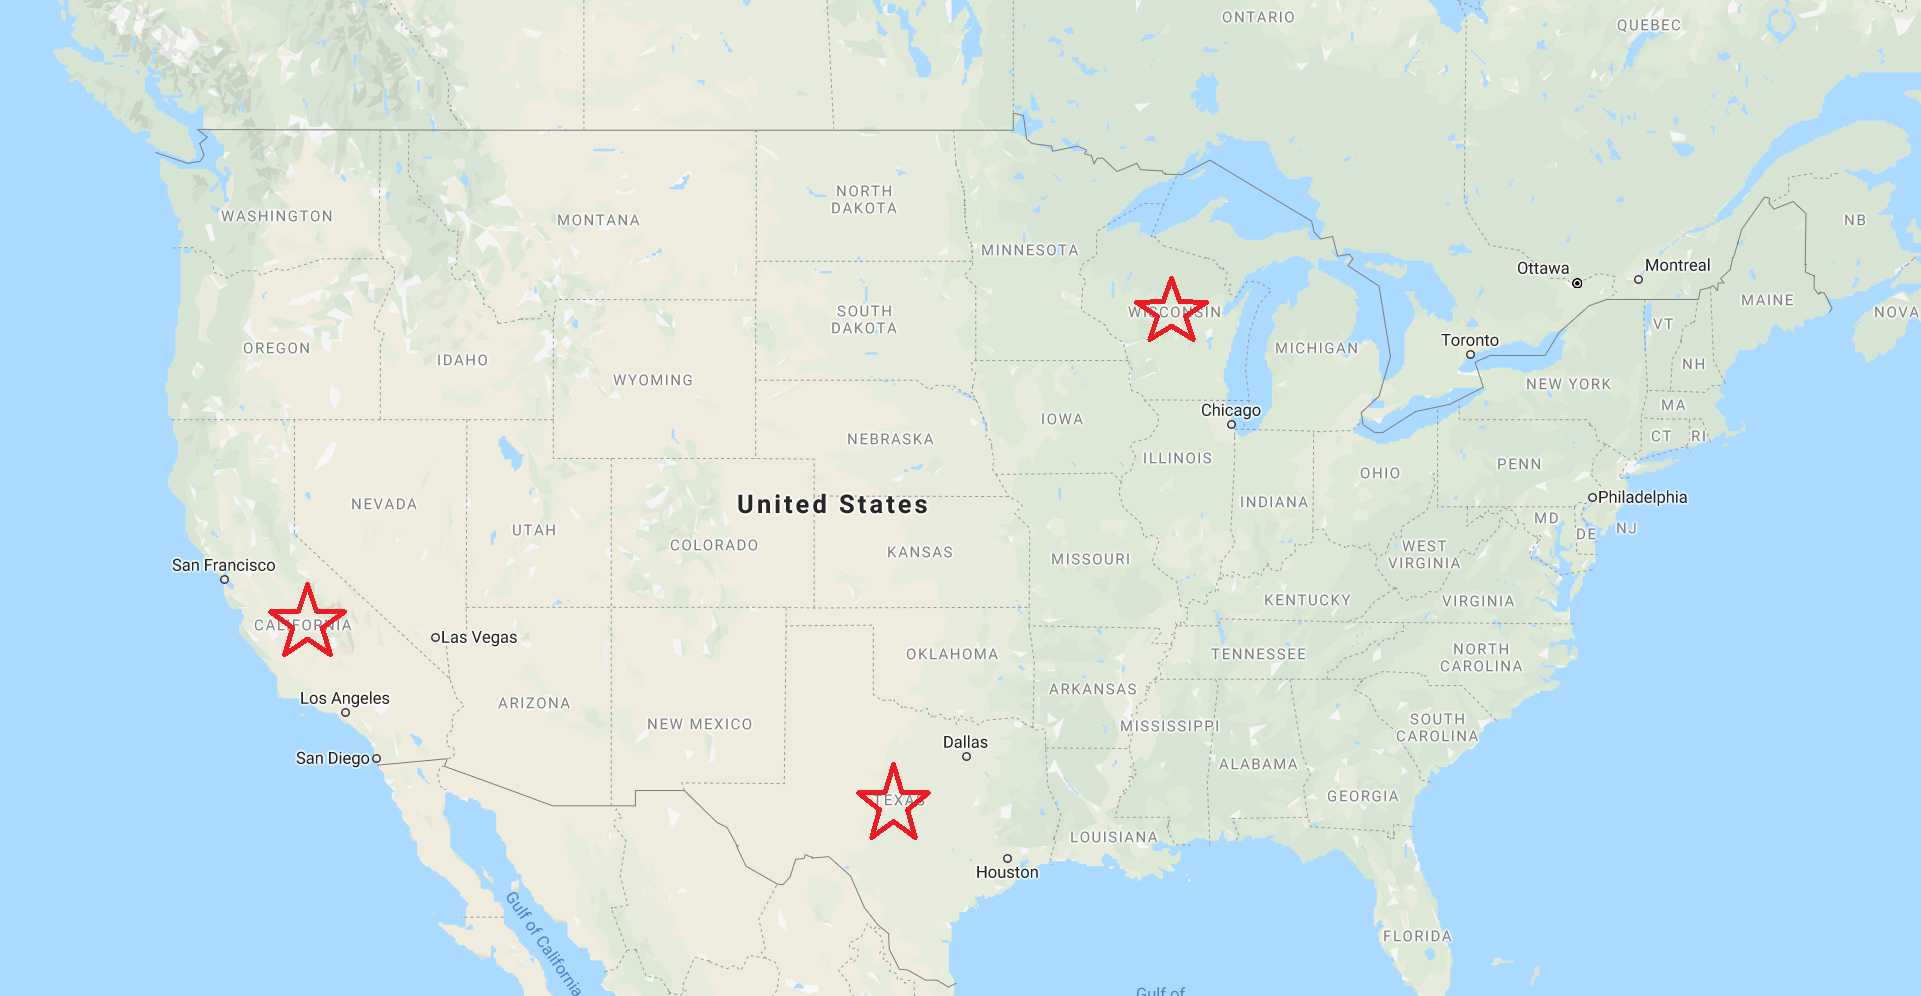

*From Google Map

In [ ]:
sell_prices_item = sell_prices[["store_id", "item_id"]].drop_duplicates()
sell_prices_item.groupby("item_id").count().query("store_id != 10")

All stores sell the same items

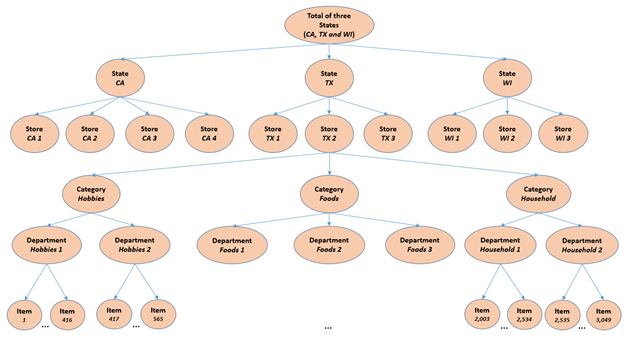

*From https://mofc.unic.ac.cy/m5-competition/

### calendar.csv

In [ ]:
calendar.info()

In [ ]:
calendar.isnull().sum()

In [ ]:
calendar.head()

In [ ]:
calendar.tail()

In [ ]:
calendar.query("snap_CA == 1")

### sales_train_validation.csv

In [ ]:
sales_train_validation.head()

In [ ]:
# This code is from https://www.kaggle.com/tpmeli/visual-guide-3-m5-baselines-eda-sarima

d_cols = ['d_' + str(i + 1) for i in range(1913)]

tidy_df = pd.melt(frame = sales_train_validation, 
                  id_vars = ['id', 'item_id', 'cat_id', 'store_id'],
                  var_name = 'd',
                  value_vars = d_cols,
                  value_name = 'sales')
new_ids = tidy_df['id'] + '_' + tidy_df['d']
tidy_df['id'] = new_ids
group = sales_train_validation.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

In [ ]:
df = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True, )
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold',legend_title_text='State',xaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'),
                 yaxis=dict(linecolor='black',linewidth=2,mirror=True,ticks='inside'))
fig.show()